In [12]:
import os
import csv
import cv2
import openslide
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from skimage.filters import threshold_otsu
from sklearn.model_selection import StratifiedShuffleSplit
from keras import layers, models
from keras import backend as K
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from openslide.deepzoom import DeepZoomGenerator

Using TensorFlow backend.


In [2]:
# preprocessing.py
def get_data_path():
    slide_paths, mask_paths = {}, {}
    with open('./train.txt', 'r') as f:
        for idx, line in enumerate(f):
            path = line.rstrip('\n')
            slide_paths[idx] = path
    
    with open('./train_mask.txt', 'r') as f:
        for idx, line in enumerate(f):
            path = line.rstrip('\n')
            mask_paths[idx] = path
            
    return slide_paths, mask_paths

In [3]:
# preprocessing.py
def open_slide(slide_path):
    return openslide.open_slide(slide_path)

def create_tiles(slide, tile_size, overlap=0):
    tiles = DeepZoomGenerator(slide, tile_size=tile_size,
                              overlap=overlap, limit_bounds=False)
    return tiles

In [4]:
patch_size = 256
slide_path = '../data/train/image/positive/Slide003.mrxs'
truth_path = '../data/train/mask/positive/Slide003.png'
slide_contains_tumor = 'pos' in slide_path

In [7]:
# preprocessing.py
def create_patches(slide_path, 
                   truth_path, 
                   patch_size=256,
                   filter_non_tissue=True,
                   filter_only_all_tumor=True):
    # 해당 데이터가 양성인지 판단
    slide_contains_tumor = 'pos' in slide_path

    # read_region을 위한 start, level, size 계산
    bounds_offset_props = (openslide.PROPERTY_NAME_BOUNDS_X, openslide.PROPERTY_NAME_BOUNDS_Y)
    bounds_size_props = (openslide.PROPERTY_NAME_BOUNDS_WIDTH, openslide.PROPERTY_NAME_BOUNDS_HEIGHT)

    slide = open_slide(slide_path)
    start = (0, 0)
    size_scale = (1, 1)
    level = int(np.log2(patch_size))
    l_dimensions = [(int(np.ceil(dim_x * size_scale[0])), int(np.ceil(dim_y * size_scale[1])))
                    for dim_x, dim_y in slide.level_dimensions]
    size = l_dimensions[level]

    if slide_contains_tumor: 
        start = (int(slide.properties.get(bounds_offset_props[0], 0)), 
                 int(slide.properties.get(bounds_offset_props[1], 0)))
        size_scale = tuple(int(slide.properties.get(prop, dim)) / dim 
                           for prop, dim in zip(bounds_size_props, slide.dimensions))

        truth = open_slide(truth_path)
        z_dimensions = []
        z_size = truth.dimensions
        z_dimensions.append(z_size)
        while z_size[0] > 1 or z_size[1] > 1:
            z_size = tuple(max(1, int(np.ceil(z/2))) for z in z_size)
            z_dimensions.append(z_size)
        size = z_dimensions[level-4]
    slide4 = slide.read_region(start, level, size)
        
    # is_tissue 부분
    slide4_grey = np.array(slide4.convert('L'))

    # background에 대한 작업
    slide4_not_black = slide4_grey[slide4_grey > 0]
    # thresh = threshold_otsu(slide4_not_black)
    ret, th = cv2.threshold(slide4_not_black, 0, 255, 
                            cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    binary = slide4_grey > 0  # black == 0
    h, w = slide4_grey.shape
    for i in range(h):
        for j in range(w):
            if slide4_grey[i, j] > ret:
                binary[i, j] = False

    # patch_df
    patches = pd.DataFrame(pd.DataFrame(binary).stack(), columns=['is_tissue'])
    patches.loc[:, 'slide_path'] = slide_path
    
    # is_tumor 부분
    if slide_contains_tumor:
        truth = open_slide(truth_path)
        thumbnail_truth = truth.get_thumbnail(size)

        # truth pathes_df
        patches_y = pd.DataFrame(
                pd.DataFrame(np.array(thumbnail_truth.convert('L'))).stack())
        patches_y['is_tumor'] = patches_y[0] > 0

        # mask된 영역이 애매한 경우
        patches_y['is_all_tumor'] = patches_y[0] == 255
        patches_y.drop(0, axis=1, inplace=True)
        samples = pd.concat([patches, patches_y], axis=1)
    else: 
        samples = patches
        samples.loc[:, 'is_tumor'] = False
        samples.loc[:, 'is_all_tumor'] = False

    slide.close()
    truth.close()
    
    del slide, truth
    
    if filter_non_tissue:  # tissue인것만 가져오기
        samples = samples[samples['is_tissue'] == True]
        
    if filter_only_all_tumor:  # 어떤 의미?
        samples['tile_loc'] = list(samples.index)
        all_tissue_samples = samples[samples['is_tumor'] == False]
        all_tissue_samples = all_tissue_samples.append(samples[samples['is_all_tumor'] == True])
        all_tissue_samples.reset_index(inplace=True, drop=True)
    else:
        return samples
    
    return all_tissue_samples

In [8]:
all_tissue_samples = create_patches(slide_path, truth_path)

In [9]:
all_tissue_samples['is_tumor'].value_counts()

False    74490
True     30723
Name: is_tumor, dtype: int64

In [13]:
def color_perturbation(image):      
    image = tf.image.random_brightness(image, max_delta=64./ 255.)
    image = tf.image.random_saturation(image, lower=0, upper=0.25)
    image = tf.image.random_hue(image, max_delta=0.04)
    image = tf.image.random_contrast(image, lower=0, upper=0.75)
    init = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init)
    
    return sess.run(image)

In [29]:
# train.py
file_handles = []
def generator(samples,
              slide_paths,
              truth_paths,
              batch_size,
              patch_size=256,
              shuffle=True):
    
    slide0 = open_slide(slide_paths[0])
    slide1 = open_slide(slide_paths[1])
    slide2 = open_slide(slide_paths[2])
    slide3 = open_slide(slide_paths[3])

    file_handles.append(slide0)
    file_handles.append(slide1)
    file_handles.append(slide2)
    file_handles.append(slide3)

    # tiles
    tiles0 = create_tiles(slide0, tile_size=patch_size)
    tiles1 = create_tiles(slide1, tile_size=patch_size)
    tiles2 = create_tiles(slide2, tile_size=patch_size)
    tiles3 = create_tiles(slide3, tile_size=patch_size)

    start_x0, start_y0 = 0, 0
    start_x1, start_y1 = 0, 0
    start_x2, start_y2 = 0, 0
    start_x3, start_y3 = 0, 0
    if 'pos' in slide_paths[0]:
        start_x0 = int(slide0.properties.get('openslide.bounds-x', 0)) / patch_size
        start_y0 = int(slide0.properties.get('openslide.bounds-y', 0)) / patch_size
        truth0 = open_slide(truth_paths[0])
        truth_tiles0 = create_tiles(truth0, tile_size=16)
    
    if 'pos' in slide_paths[1]: 
        start_x1 = int(slide1.properties.get('openslide.bounds-x', 0)) / patch_size
        start_y1 = int(slide1.properties.get('openslide.bounds-y', 0)) / patch_size
        truth1 = open_slide(truth_paths[1])
        truth_tiles1 = create_tiles(truth1, tile_size=16)
        
    if 'pos' in slide_paths[2]:
        start_x2 = int(slide2.properties.get('openslide.bounds-x', 0)) / patch_size
        start_y2 = int(slide2.properties.get('openslide.bounds-y', 0)) / patch_size
        truth2 = open_slide(truth_paths[2])
        truth_tiles2 = create_tiles(truth2, tile_size=16)
        
    if 'pos' in slide_paths[3]:
        start_x3 = int(slide3.properties.get('openslide.bounds-x', 0)) / patch_size
        start_y3 = int(slide3.properties.get('openslide.bounds-y', 0)) / patch_size
        truth3 = open_slide(truth_paths[3])
        truth_tiles3 = create_tiles(truth3, tile_size=16)
        
    num_samples = len(samples)
    while 1:
        if shuffle:
            samples = samples.sample(frac=1)  # shuffling

        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]

            batch_tiles, batch_masks = [], []
            for slide_path, (y, x) in zip(batch_samples['slide_path'].values, 
                                          batch_samples['tile_loc'].values):
                
                mask_tile_zoom = np.zeros((patch_size,patch_size))
                if slide_path == slide_paths[0]:
                    img = tiles0.get_tile(tiles0.level_count-1, (x+start_x0, y+start_y0))
                    if 'pos' in slide_path:
                        mask_tile = truth_tiles0.get_tile(truth_tiles0.level_count-1, (x, y))
                        mask_tile = (cv2.cvtColor(np.array(mask_tile), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                        # mask_size_up , 16 to 256
                        k, l = mask_tile.shape
                        for i in range(k):
                            for j in range(l):
                                for o in range(16):
                                    for p in range(16):
                                        mask_tile_zoom[i*16+o,j*16+p] = mask_tile[i][j]
                        
                elif slide_path == slide_paths[1]:
                    img = tiles1.get_tile(tiles1.level_count-1, (x+start_x1, y+start_y1))
                    if 'pos' in slide_path:
                        mask_tile = truth_tiles1.get_tile(truth_tiles1.level_count-1, (x, y))
                        mask_tile = (cv2.cvtColor(np.array(mask_tile), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                        # mask_size_up , 16 to 256
                        k, l = mask_tile.shape
                        for i in range(k):
                            for j in range(l):
                                for o in range(16):
                                    for p in range(16):
                                        mask_tile_zoom[i*16+o,j*16+p] = mask_tile[i][j]
                
                elif slide_path == slide_paths[2]:
                    img = tiles2.get_tile(tiles2.level_count-1, (x+start_x2, y+start_y2))
                    if 'pos' in slide_path:
                        mask_tile = truth_tiles2.get_tile(truth_tiles2.level_count-1, (x, y))
                        mask_tile = (cv2.cvtColor(np.array(mask_tile), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                        # mask_size_up , 16 to 256
                        k, l = mask_tile.shape
                        for i in range(k):
                            for j in range(l):
                                for o in range(16):
                                    for p in range(16):
                                        mask_tile_zoom[i*16+o,j*16+p] = mask_tile[i][j]

                elif slide_path == slide_paths[3]:
                    img = tiles3.get_tile(tiles3.level_count-1, (x+start_x3, y+start_y3))
                    if 'pos' in slide_path:
                        mask_tile = truth_tiles3.get_tile(truth_tiles3.level_count-1, (x, y))
                        mask_tile = (cv2.cvtColor(np.array(mask_tile), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                        # mask_size_up , 16 to 256
                        k, l = mask_tile.shape
                        for i in range(k):
                            for j in range(l):
                                for o in range(16):
                                    for p in range(16):
                                        mask_tile_zoom[i*16+o,j*16+p] = mask_tile[i][j]

                
                if img.size != (patch_size, patch_size):
                    img = Image.new('RGB', (patch_size, patch_size))
                    mask_tile_zoom = np.zeros((patch_size, patch_size))
                    
                batch_tiles.append(np.array(img))
                batch_masks.append(mask_tile_zoom)
                
            # train_x & train_y
            train_x = np.array(batch_tiles)
            train_y = to_categorical(np.array(batch_masks), num_classes=2)
            
            train_x, train_y = next(
                ImageDataGenerator(rotation_range=90,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   brightness_range =(0.65, 1.)).flow(train_x, y=train_y, batch_size=batch_size))
            
            train_x /= 255.
            yield train_x, train_y

In [30]:
slide_4_test = [[55,55, 0, 0]]

In [31]:
slide_paths = [slide_path] * 4
mask_paths =  [truth_path] *4

In [32]:
samples = create_patches(slide_path, truth_path)

In [33]:
train_gen = generator(samples, slide_paths, mask_paths, batch_size=32)

In [34]:
train_x, train_y = next(train_gen)

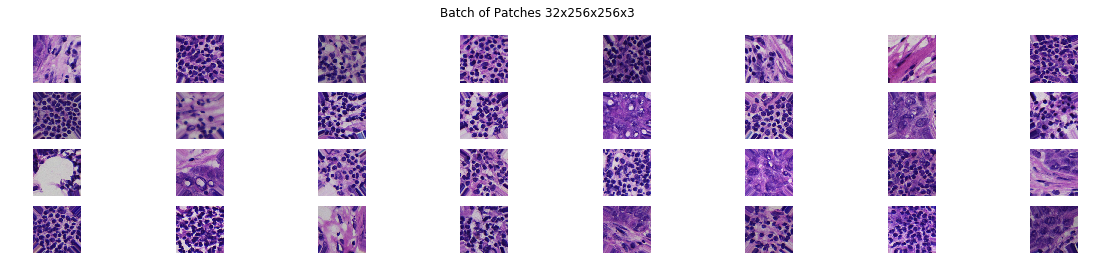

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

f, axes = plt.subplots(4, 8, figsize=(20, 4));
ax = axes.flatten()
for i in range(0, train_x.shape[0]):
    _ = ax[i].imshow(train_x[i]);
    _ = ax[i].axis('off');
f.suptitle('Batch of Patches 32x256x256x3');

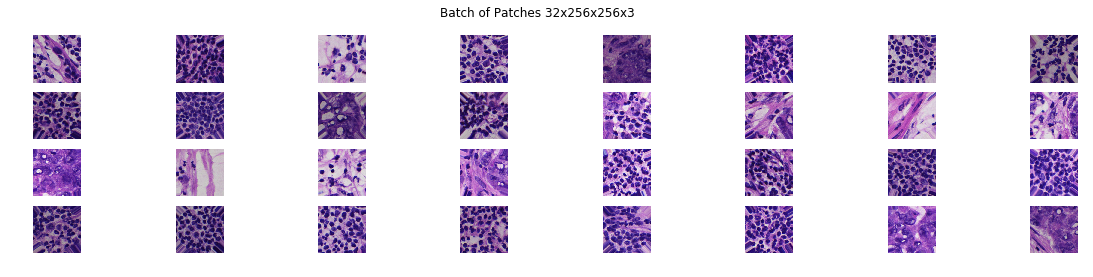

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt

f, axes = plt.subplots(4, 8, figsize=(20, 4));
ax = axes.flatten()
for i in range(0, train_x.shape[0]):
    _ = ax[i].imshow(train_x[i]);
    _ = ax[i].axis('off');
f.suptitle('Batch of Patches 32x256x256x3');